# Melting Dynamics

This is a notebook to understand the dynamics of crystal melting, in particular how much of the slowdown of the melting can be attributed to the slow dynamics.

In [1]:
# Import required modules
import pandas as pd
import numpy as np
import altair.vegalite.v2 as alt
from ipywidgets import interact, ToggleButtons, IntSlider

## Input data

The data for this notebook is sourced from the calculations of the relaxation times which can be run using the makefile in the home directory of this repository. The command `make relaxations` will compute the relaxation values that are required for this analysis, although if not run previously the command `make dynamics` will also need to be run as I am yet to set up any dependencies in the Makefile.

The calculation of the melting rates is performed in the [Crystal_Clustering](Crystal_Clustering.ipynb) notebook from calculations of crystal fractions from running `make melting`.

In [7]:
df_relax = pd.read_hdf('../data/analysis/dynamics_clean_agg.h5', 'relaxations')
df_melting = pd.read_hdf("../data/analysis/melting.h5", "rates")

df_timescales = df_relax.merge(df_melting, on=['temperature', 'pressure'])

In [6]:
df_timescales.head()

,temperature,pressure,index_value,index_lower,index_upper,alpha_value,alpha_lower,alpha_upper,com_struct_value,com_struct_lower,...,struct_value,struct_lower,struct_upper,inv_diffusion_value,inv_diffusion_lower,inv_diffusion_upper,crystal,temp_norm,mean,error
0,0.30,1.0,NaN,NaN,NaN,82455176.00,8.037706e+07,87564339.00,1.148239e+09,1.145028e+09,...,5.781875e+08,5.775309e+08,5.799684e+08,NaN,NaN,NaN,p2,0.833333,3.482835e-10,1.356480e-09
1,0.32,1.0,NaN,NaN,NaN,18812476.20,1.812581e+07,20488152.04,9.977559e+07,9.961881e+07,...,6.872281e+07,6.865647e+07,6.889176e+07,9.340425e+07,9.337719e+07,9.347569e+07,p2,0.888889,1.158523e-09,2.048452e-09
2,0.36,1.0,NaN,NaN,NaN,902678.00,8.591131e+05,995338.96,3.895025e+06,3.846236e+06,...,2.298999e+06,2.268974e+06,2.365793e+06,3.840824e+06,3.838640e+06,3.846158e+06,p2,1.000000,-2.633343e-09,2.242914e-09
3,0.38,1.0,NaN,NaN,NaN,305670.00,2.928147e+05,334947.37,NaN,NaN,...,NaN,NaN,NaN,1.271341e+06,1.270236e+06,1.273924e+06,p2,1.055556,-6.604699e-09,2.695049e-09
4,0.40,1.0,NaN,NaN,NaN,59481.62,5.763231e+04,63593.17,2.549309e+05,2.522658e+05,...,1.711767e+05,1.693425e+05,1.759726e+05,3.461727e+05,3.453189e+05,3.484867e+05,p2,1.111111,-5.662076e-08,4.335606e-09


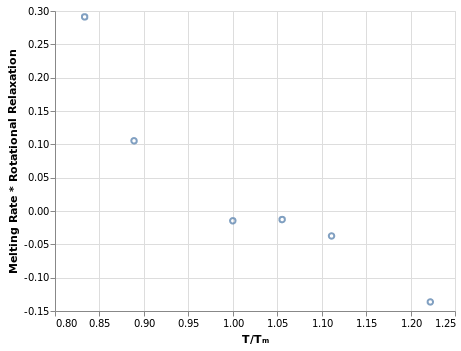

In [21]:
c = alt.Chart(df_timescales).mark_point().encode(
    x=alt.X('temp_norm', title='T/Tₘ', scale=alt.Scale(zero=False)),
    y=alt.Y("scaling:Q", title='Melting Rate * Rotational Relaxation')
).transform_calculate(
    scaling = alt.datum.mean * alt.datum.rot2_value
)

c

In [23]:
def theory(x, enthalpy, c):
    result = 1 - np.exp((1-x) * enthalpy / x)
    return c * result

In [24]:
import scipy.optimize

In [28]:
opt, err = scipy.optimize.curve_fit(
    theory, 
    df_timescales.temp_norm, 
    df_timescales["mean"] * df_timescales.rot2_value
)

In [29]:
df_fit = pd.DataFrame({
    "temp_norm": df_timescales.temp_norm, 
    "scaling": df_timescales["mean"] * df_timescales["rot2_value"],
    "theory": theory(df_timescales.temp_norm, *opt)
})

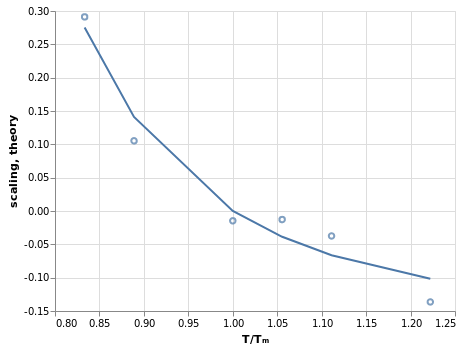

In [30]:
c = alt.Chart(df_fit).encode(
    x=alt.X('temp_norm', title='T/Tₘ', scale=alt.Scale(zero=False)),
)

c.mark_point().encode(y="scaling") + c.mark_line().encode(y="theory")

In [35]:
print(f"""
The above plot uses the values computed from the curve fit with;
- enthalpy: {opt[0]:.2f}, and
- constant: {opt[1]:.2f}
""")


The above plot uses the values computed from the curve fit with;
- enthalpy: 4.69, and
- constant: -0.18

